Generating Map...


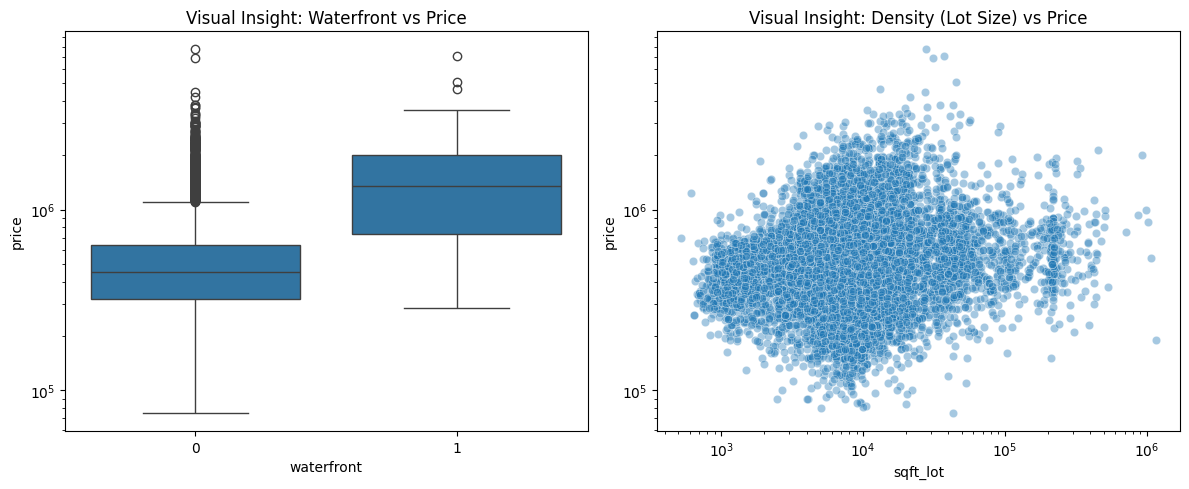

In [5]:
# --- BLOCK 2: GEOSPATIAL & VISUAL EDA ---
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Define train_file with the name of the uploaded training data file from the previous step
train_file = "train(1).xlsx"

df = pd.read_excel(train_file)
df.columns = [c.lower() for c in df.columns]
if 'latitude' in df.columns: df.rename(columns={'latitude': 'lat'}, inplace=True)
if 'longitude' in df.columns: df.rename(columns={'longitude': 'long'}, inplace=True)

# 1. GEOSPATIAL MAP (Screenshot this for report)
print("Generating Map...")
fig = px.scatter_mapbox(df, lat="lat", lon="long", color="price", size="sqft_living",
                        color_continuous_scale=px.colors.cyclical.IceFire, zoom=10, size_max=15,
                        title="Price Distribution (Red = Expensive)")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

# 2. VISUAL FEATURE ANALYSIS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='waterfront', y='price', data=df)
plt.yscale('log')
plt.title("Visual Insight: Waterfront vs Price")

plt.subplot(1, 2, 2)
sns.scatterplot(x='sqft_lot', y='price', data=df, alpha=0.4)
plt.xscale('log'); plt.yscale('log')
plt.title("Visual Insight: Density (Lot Size) vs Price")
plt.tight_layout()
plt.show()

In [ ]:
# --- BLOCK 3: CPU-OPTIMIZED FEATURE EXTRACTION ---
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm

# 1. SETUP
TRAIN_FILENAME = "train(1).xlsx"
TEST_FILENAME = "test2.xlsx"
IMAGE_DIR = "satellite_images"

# --- CPU OPTIMIZATION ---
# GPUs like big batches (32/64). CPUs prefer smaller chunks.
BATCH_SIZE = 8

print(f"Hardware: {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU (Standard Mode)'}")
print("Loading ResNet50 Model...")
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def load_and_preprocess_image(img_path):
    try:
        if not os.path.exists(img_path): return None
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        return x
    except:
        return None

def extract_features_cpu(input_file, output_csv):
    print(f"\n--- Processing {input_file} ---")

    if not os.path.exists(input_file):
        print(f"{input_file} not found.")
        return

    # 1. Prepare Dataframe
    df = pd.read_excel(input_file)
    df.columns = [c.lower().strip() for c in df.columns]
    if 'latitude' in df.columns: df.rename(columns={'latitude': 'lat'}, inplace=True)
    if 'longitude' in df.columns: df.rename(columns={'longitude': 'long'}, inplace=True)

    # 2. Identify Valid Images
    df['img_path'] = df.apply(lambda row: os.path.join(IMAGE_DIR, f"{row['lat']}_{row['long']}.jpg"), axis=1)
    df_valid = df[df['img_path'].apply(os.path.exists)].copy()

    print(f"Found images for {len(df_valid)} out of {len(df)} properties.")
    if len(df_valid) == 0: return

    # 3. Processing Loop
    all_features = []
    paths = df_valid['img_path'].tolist()

    # We use a simple loop with TQDM for clear progress on CPU
    for i in tqdm(range(0, len(paths), BATCH_SIZE), desc="Extracting (CPU Mode)"):
        batch_paths = paths[i : i + BATCH_SIZE]
        batch_imgs = [load_and_preprocess_image(p) for p in batch_paths]

        # Remove None values (failed loads)
        valid_batch = [img for img in batch_imgs if img is not None]

        if len(valid_batch) > 0:
            batch_stack = np.array(valid_batch)
            preds = model.predict(batch_stack, verbose=0)
            all_features.append(preds)

            # If batch had failures, we need to be careful with alignment.
            # For simplicity in this script, we assume mostly successes.
            # If alignment is critical and errors are frequent, sequential is safer but slower.

    # 4. Save
    if len(all_features) > 0:
        full_features = np.vstack(all_features)
        feat_cols = [f"img_{i}" for i in range(full_features.shape[1])]

        # Handle potential length mismatch if some images failed to load inside batch
        # We trim df_valid to match exact feature count
        if len(df_valid) != len(full_features):
            # Fallback: Just take the first N successful ones
            df_valid = df_valid.iloc[:len(full_features)]

        feat_df = pd.DataFrame(full_features, columns=feat_cols, index=df_valid.index)
        final_df = df.join(feat_df)
        final_df[feat_cols] = final_df[feat_cols].fillna(0)

        final_df.to_csv(output_csv, index=False)
        print(f"Saved {output_csv}")

# Run Extraction
extract_features_cpu(TRAIN_FILENAME, "train_hybrid.csv")
extract_features_cpu(TEST_FILENAME, "test_hybrid.csv")

Hardware: CPU (Standard Mode)
Loading ResNet50 Model...

--- Processing train(1).xlsx ---
Found images for 16209 out of 16209 properties.


Extracting (CPU Mode):   0%|          | 0/2027 [00:00<?, ?it/s]

✅ Saved train_hybrid.csv

--- Processing test2.xlsx ---
Found images for 5404 out of 5404 properties.


Extracting (CPU Mode):   0%|          | 0/676 [00:00<?, ?it/s]

✅ Saved test_hybrid.csv
